## Load the data with features as Mass, Radius and K2 


In [137]:
import pandas as pd 

data = pd.read_csv("custom_sample_mass_radius_k2_15.csv", 
                   header=None, 
                   names=["Mass", "Radius", "k2", "Type"], 
                   low_memory=False)

mass_radius_k2 = data.iloc[1:,:-1]
star_type = data.iloc[1:,-1]
stat_type = star_type.astype(int)

In [138]:
star_type.value_counts() # Count the occurrences of each star type

Type
1    32464
0    31554
Name: count, dtype: int64

### Split the data into training and testing sets and loading the necessary libraries 

In [139]:


import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, make_scorer, precision_score, recall_score, f1_score, roc_curve, auc , confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mass_radius_k2, star_type.astype(int), train_size=0.05, random_state=42, stratify=star_type.astype(int))





### KNN Classifier

test_precision_macro: 0.9760 ± 0.0040
test_recall_macro: 0.9755 ± 0.0045
test_f1_macro: 0.9756 ± 0.0044
test_accuracy: 0.9756 ± 0.0044


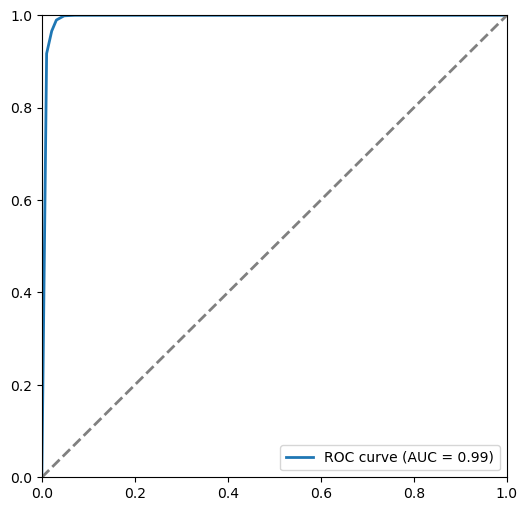

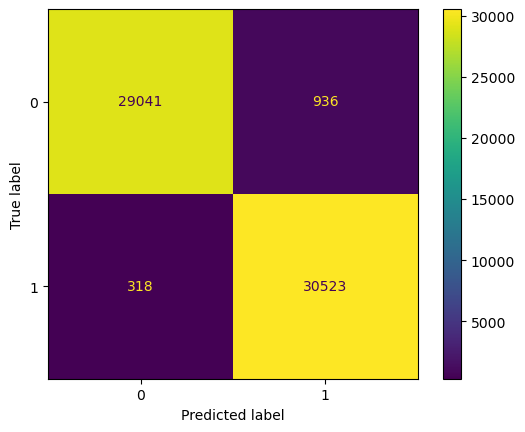

accuracy score:97.94%
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     29977
           1       0.97      0.99      0.98     30841

    accuracy                           0.98     60818
   macro avg       0.98      0.98      0.98     60818
weighted avg       0.98      0.98      0.98     60818



In [144]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

scores = cross_validate(classifier, X_train, y_train, cv=cv, scoring=scoring)

for key in ['test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_accuracy']:
    print(f"{key}: {np.mean(scores[key]):.4f} ± {np.std(scores[key]):.4f}")


classifier.fit(X_train, y_train)
y_test_proba = classifier.predict_proba(X_test)[:,1]
y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()
fpr, tpr, _ = roc_curve(y_test_bin,y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.show()

m_r_prediction = classifier.predict(X_test)
cm = confusion_matrix(y_test, m_r_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()
print(f"accuracy score:{accuracy_score(y_test, m_r_prediction) * 100:.2f}%")
print(classification_report(y_test, m_r_prediction))



## Random Forest


Cross-validation results:
test_accuracy: 0.9571 ± 0.0182
test_precision: 0.9610 ± 0.0151
test_recall: 0.9566 ± 0.0185
test_f1: 0.9569 ± 0.0184


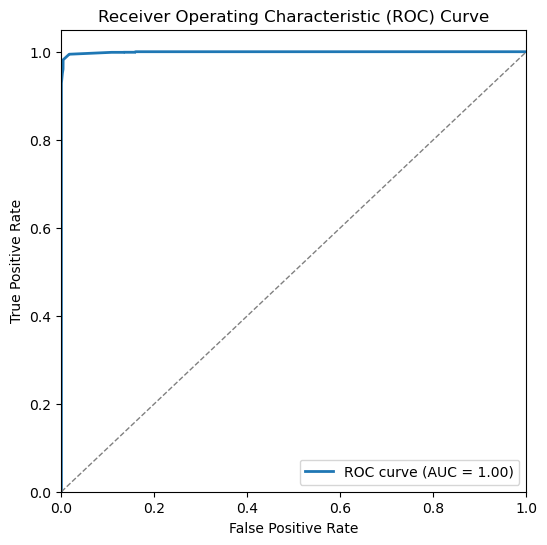

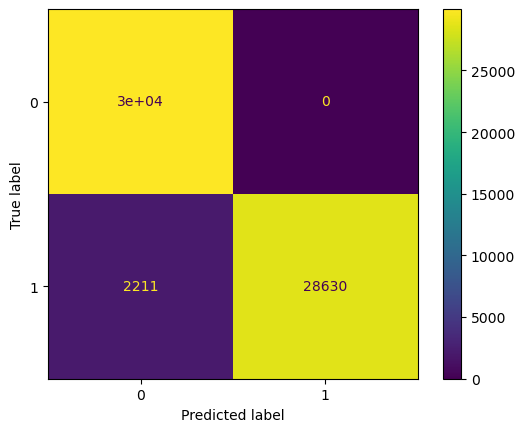

accuracy score:96.36%
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     29977
           1       1.00      0.93      0.96     30841

    accuracy                           0.96     60818
   macro avg       0.97      0.96      0.96     60818
weighted avg       0.97      0.96      0.96     60818



In [141]:
from sklearn.ensemble import RandomForestClassifier 

classifier = RandomForestClassifier(
    n_estimators=5,
    max_depth=3,
    max_features=1,
    random_state=0
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average='macro'),
    "recall": make_scorer(recall_score, average='macro'),
    "f1": make_scorer(f1_score, average='macro')
}

# Run cross-validation
scores = cross_validate(classifier, mass_radius_k2, star_type, cv=cv, scoring=scoring)

# Print mean ± std for each metric
print("Cross-validation results:")
for key in ["test_accuracy", "test_precision", "test_recall", "test_f1"]:
    mean = np.mean(scores[key])
    std = np.std(scores[key])
    print(f"{key}: {mean:.4f} ± {std:.4f}")
    
    
y_proba = classifier.fit(X_train, y_train).predict_proba(X_test)[:,1]
y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# Plot ROC Curve
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

m_r_prediction = classifier.predict(X_test)
cm = confusion_matrix(y_test, m_r_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()
print(f"accuracy score:{accuracy_score(y_test, m_r_prediction) * 100:.2f}%")
print(classification_report(y_test, m_r_prediction))



##  Decision Tree Classifier 

Cross-validation results:
test_accuracy: 0.9412 ± 0.0013
test_precision: 0.9462 ± 0.0018
test_recall: 0.9417 ± 0.0016
test_f1: 0.9410 ± 0.0013


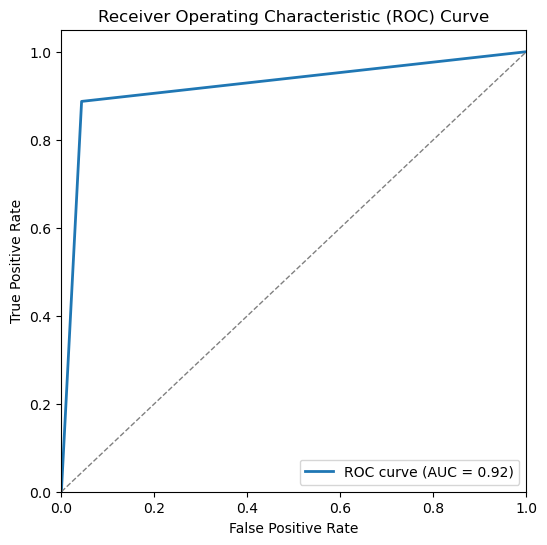

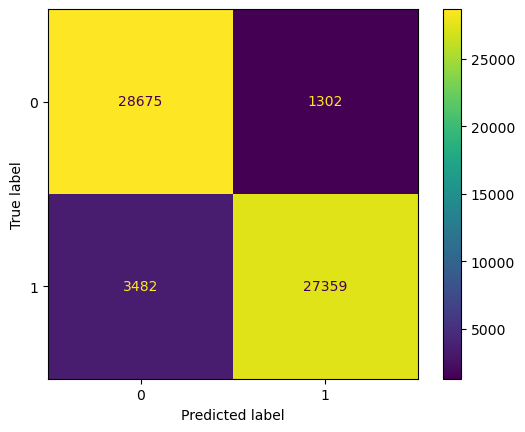

accuracy score:92.13%
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     29977
           1       0.95      0.89      0.92     30841

    accuracy                           0.92     60818
   macro avg       0.92      0.92      0.92     60818
weighted avg       0.92      0.92      0.92     60818



In [142]:
from sklearn.tree import DecisionTreeClassifier 

classifier = DecisionTreeClassifier(max_depth=2, min_samples_split=1500, min_samples_leaf=1500, random_state=0)

scoring = {
    "accuracy": "accuracy",
    "precision": make_scorer(precision_score, average='macro'),
    "recall": make_scorer(recall_score, average='macro'),
    "f1": make_scorer(f1_score, average='macro')
}

# Run cross-validation
scores = cross_validate(classifier, mass_radius_k2, star_type, cv=cv, scoring=scoring)
print("Cross-validation results:")
for key in ["test_accuracy", "test_precision", "test_recall", "test_f1"]:
    mean = np.mean(scores[key])
    std = np.std(scores[key])
    print(f"{key}: {mean:.4f} ± {std:.4f}")

y_proba = classifier.fit(X_train, y_train).predict_proba(X_test)[:,1]
y_test_bin = label_binarize(y_test, classes=[0,1]).ravel()
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# Plot ROC Curve
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

m_r_prediction = classifier.predict(X_test)
cm = confusion_matrix(y_test, m_r_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()
print(f"accuracy score:{accuracy_score(y_test, m_r_prediction) * 100:.2f}%")
print(classification_report(y_test, m_r_prediction))
